# adult dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [2]:
dataset_name = "adult"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.5799999833106995


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129.69it/s]


Elapsed time LeaveOneOut(): 0:00:00.785639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.21it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:07.038302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 121.90it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:16.444338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 11542.67it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.019634
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]

gr_stat=1.0275074924463488
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:01:24.771902
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.58it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:06.354524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.10it/s]


Elapsed time AME(num_models=1000): 0:00:24.551838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.68it/s]

Elapsed time DataOob(num_models=1000): 0:00:08.093457
CPU times: user 2min 25s, sys: 660 ms, total: 2min 25s
Wall time: 2min 28s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/adult_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.400000
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.380952
DVRL(rl_epochs=2000),0.307692
DataBanzhaf(num_models=1000),0.358974
DataOob(num_models=1000),0.311111
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.400000
InfluenceFunctionEval(num_models=1000),0.428571
KNNShapley(k_neighbors=50),0.355556
LeaveOneOut(),0.222222
RandomEvaluator(),0.107143


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

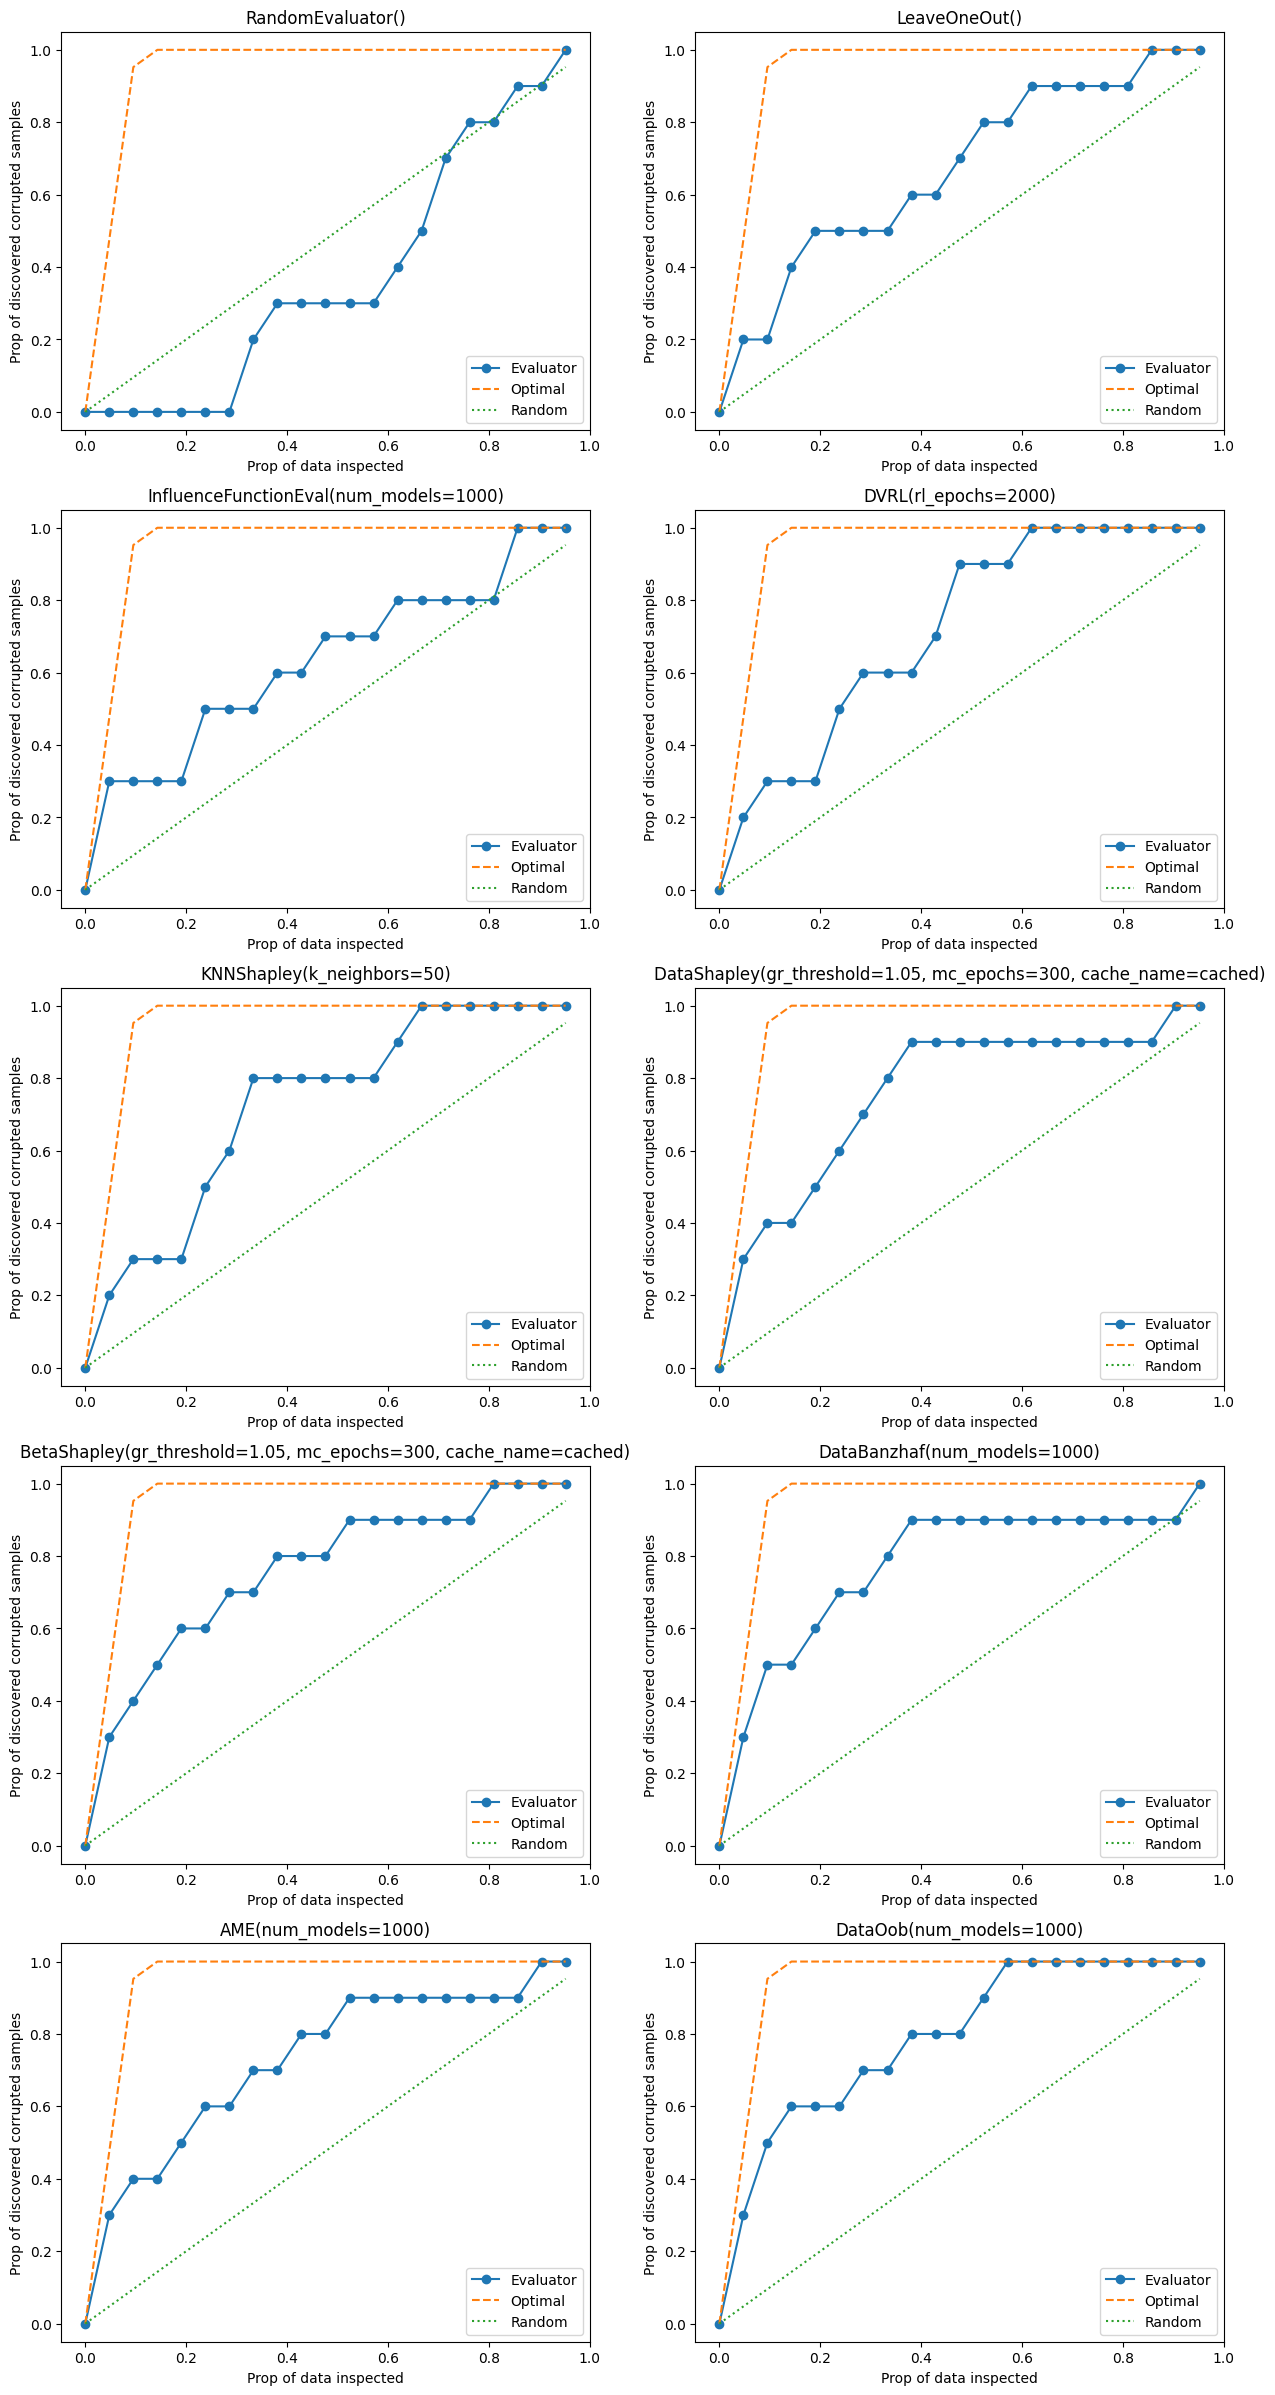

In [7]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

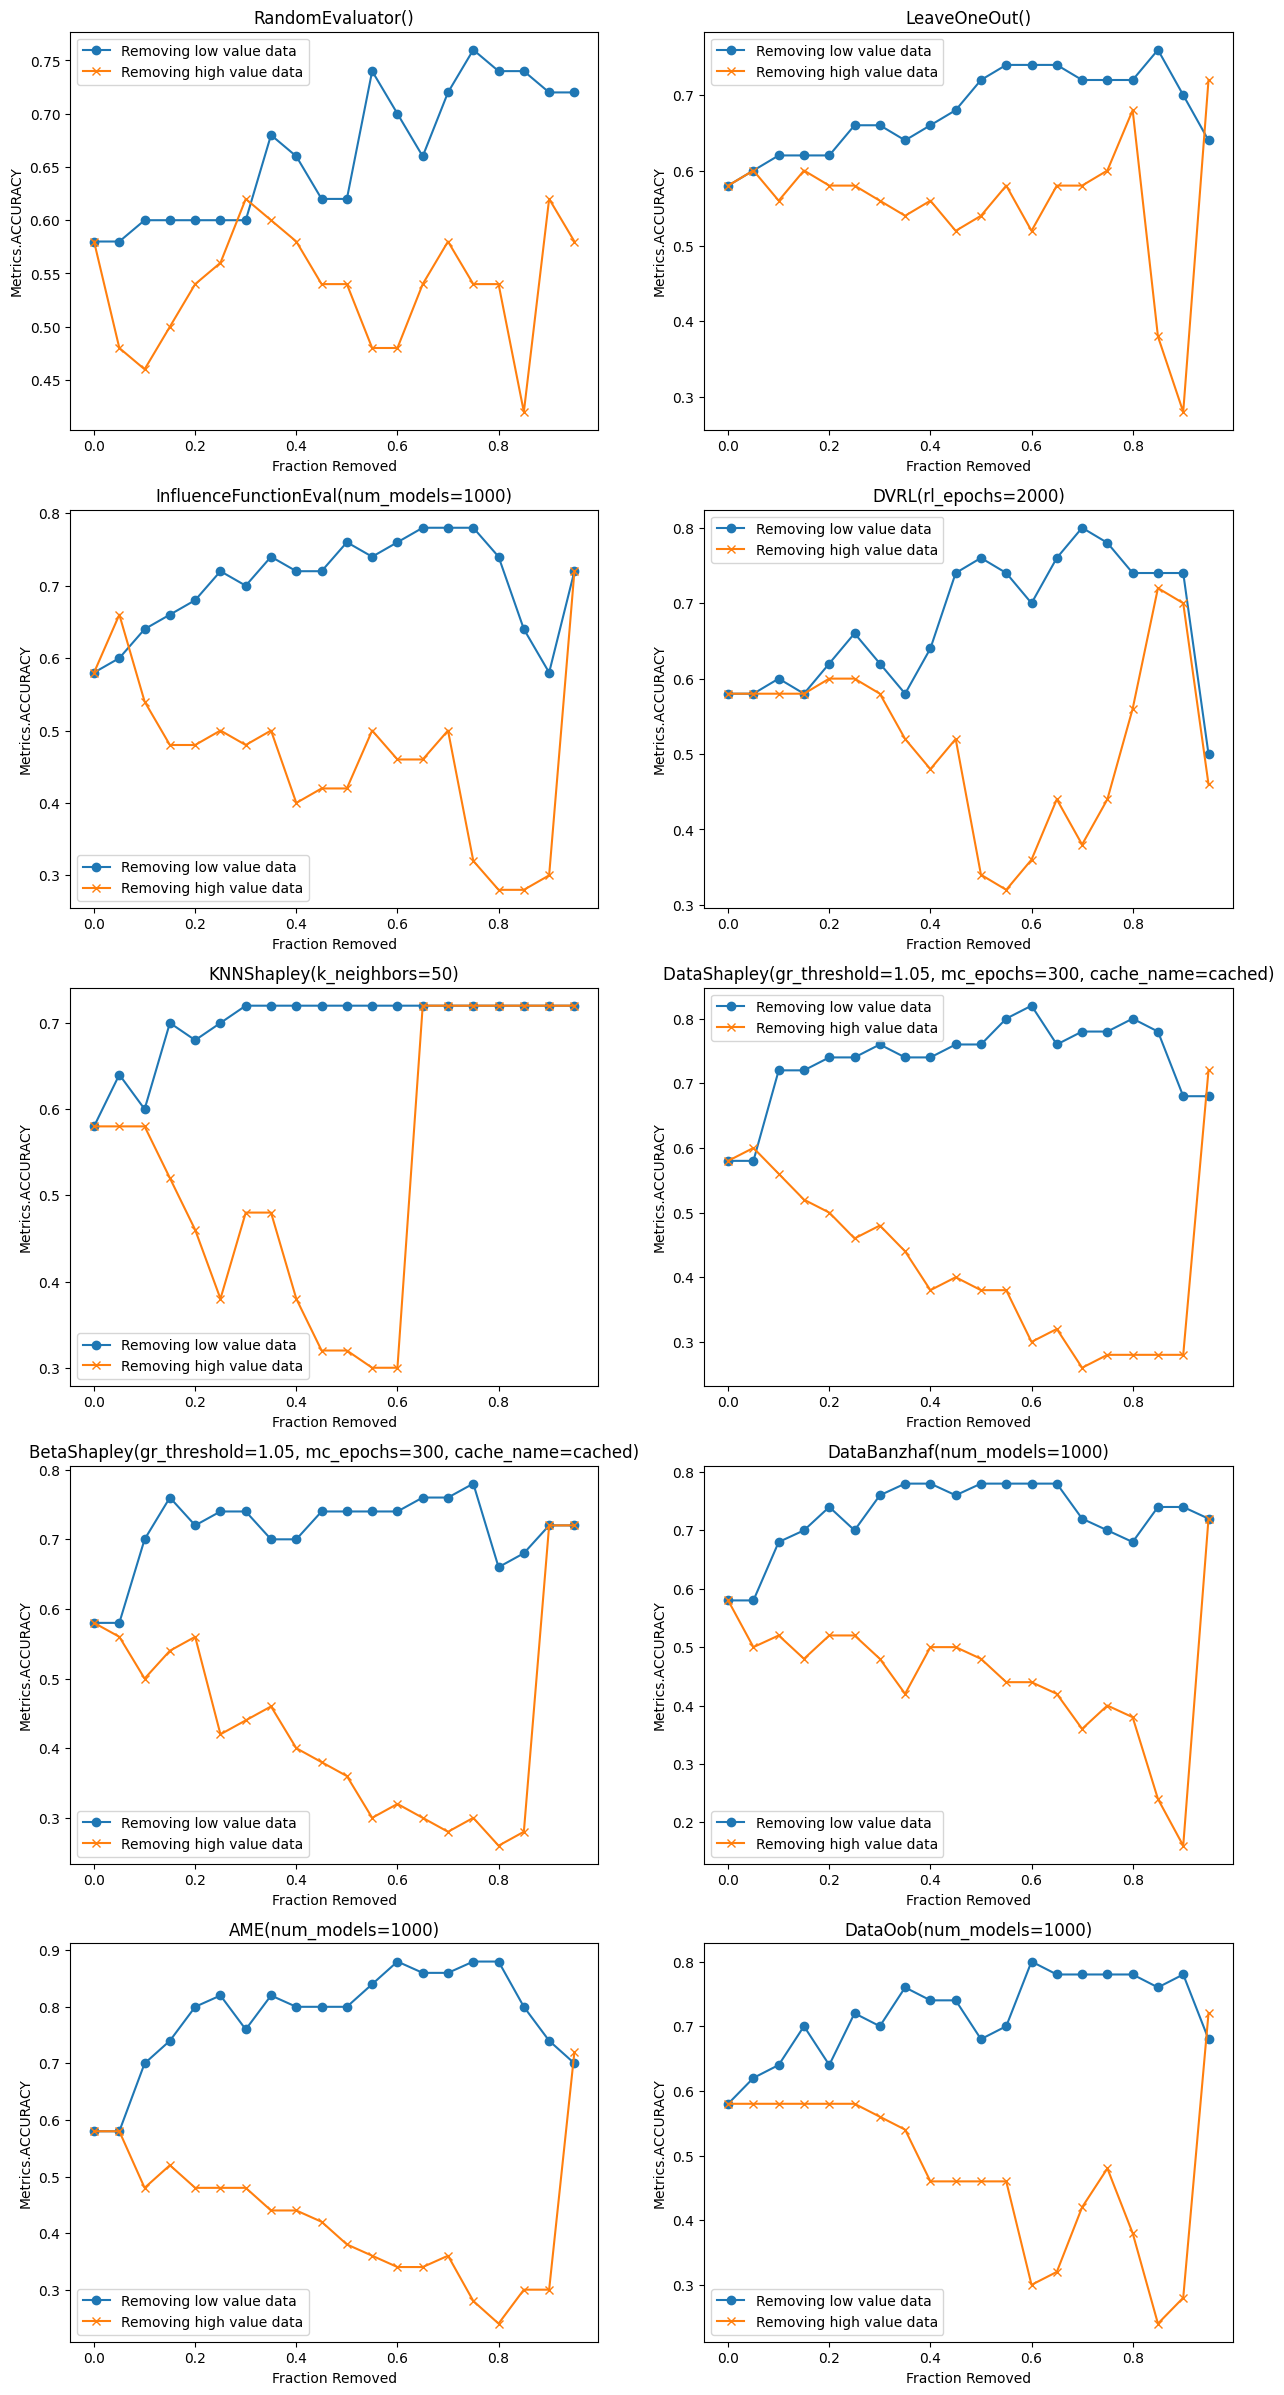

In [8]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.58,0.58,0.0
RandomEvaluator(),0.58,0.48,0.05
RandomEvaluator(),0.6,0.46,0.1
RandomEvaluator(),0.6,0.5,0.15
RandomEvaluator(),0.6,0.54,0.2
...,...,...,...
DataOob(num_models=1000),0.78,0.48,0.75
DataOob(num_models=1000),0.78,0.38,0.8
DataOob(num_models=1000),0.76,0.24,0.85
DataOob(num_models=1000),0.78,0.28,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),43124,0.785758
RandomEvaluator(),10551,0.918214
RandomEvaluator(),12185,0.675887
RandomEvaluator(),18140,0.013349
RandomEvaluator(),14363,0.174225
...,...,...
DataOob(num_models=1000),10440,0.989744
DataOob(num_models=1000),15915,0.053412
DataOob(num_models=1000),1196,0.85641
DataOob(num_models=1000),29065,0.293447
